### Init

In [1]:
import os

import torch
import yaml
from PIL import Image

from grounded_sam import (run_grounded_sam_batch, transform_image_dino,
                          transform_image_sam)
from utils import resize_preserve_aspect_ratio

final text_encoder_type: bert-base-uncased
_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])


In [2]:
def load_yaml(path):
    with open(path, "r") as file:
        data = yaml.load(file, Loader=yaml.FullLoader)
    return data


config_path = "configs/fashion_people.yml"
data = load_yaml(config_path)


def get_labels_dict(config_path):
    data = load_yaml(config_path)
    labels_dict = data.get("names")
    labels_dict = {v: k for k, v in labels_dict.items()}
    return labels_dict


device = "cuda"
config_path = "configs/fashion_people.yml"
data = load_yaml(config_path)
labels_dict = get_labels_dict(config_path)

### TEST

In [3]:
from sam_results import SAMResults
from utils import (pad_to_fixed_size, resize_preserve_aspect_ratio, unload_box,
                   unload_mask)


def load_image(image_path):
    image_pil = Image.open(image_path).convert("RGB")
    image_pil = resize_preserve_aspect_ratio(image_pil, 1024)
    image_pil = pad_to_fixed_size(image_pil, (1024, 1024))
    return image_pil


# image_dir = "datasets/person_seg/images/train"
# image_paths = [os.path.join(image_dir, file) for file in os.listdir(image_dir)]
image_paths = ["test_image_1.jpg", "test_image_2.jpg"]

images = [load_image(image_path) for image_path in image_paths[:4]]
dino_images = torch.stack([transform_image_dino(image) for image in images])
sam_images = torch.stack([transform_image_sam(image) for image in images])

dino_images = dino_images.to(device)
sam_images = sam_images.to(device)

In [4]:
labels_dict = get_labels_dict(config_path)
labels = [k for k in labels_dict.keys()]
text_prompt = " . ".join(labels)

In [5]:
# from grounded_sam import * 

In [6]:
# # determine if tensor is empty
# def is_empty(tensor):
#     return tensor.size(0) == 0


# def run_grounded_sam_batch(
#     dino_images,
#     sam_images,
#     text_prompt,
#     box_thresh=0.3,
#     text_thresh=0.25,
#     iou_thresh=0.8,
# ):
#     global box_threshold, text_threshold, iou_threshold
#     box_threshold = box_thresh
#     text_threshold = text_thresh
#     iou_threshold = iou_thresh

#     # Process with DINO model
#     boxes, scores, phrases = run_dino(dino_images, text_prompt)
#     boxes, scores, phrases = format_dino(boxes, scores, phrases)

#     # Prepare to keep track of outputs, respecting original order
#     batch_size = len(dino_images)
#     rows = [None] * batch_size  # Initialize with None for all entries

#     # Determine if any images do not have detections
#     # We do this by looking for any empty bounding boxes
#     valid_indices = [i for i, box in enumerate(boxes) if not is_empty(box)]

#     # Run any images with detections through SAM
#     if valid_indices:
#         valid_sam_images = sam_images[valid_indices]
#         valid_boxes = [boxes[i] for i in valid_indices]

#         # Process non-empty entries with SAM
#         sam_outputs = run_sam(valid_sam_images, valid_boxes)
#         valid_masks = [output.get("masks") for output in sam_outputs]
        
#         # Filter for scores and phrases that have detections
#         valid_scores = [scores[i] for i in valid_indices]
#         valid_phrases = [phrases[i] for i in valid_indices]

#         # Place processed results back in the correct order
#         for idx, mask, box, score, phrase in zip(
#             valid_indices, valid_masks, valid_boxes, valid_scores, valid_phrases
#         ):
#             rows[idx] = {
#                 "masks": mask,
#                 "boxes": box,
#                 "scores": score,
#                 "phrases": phrase,
#             }

#     # Fill in rows with None for images without detections
#     for i in range(batch_size):
#         if rows[i] is None:
#             rows[i] = {"masks": None, "boxes": None, "scores": None, "phrases": None}

#     return rows

In [7]:
unformatted_results = run_grounded_sam_batch(dino_images, sam_images, text_prompt)

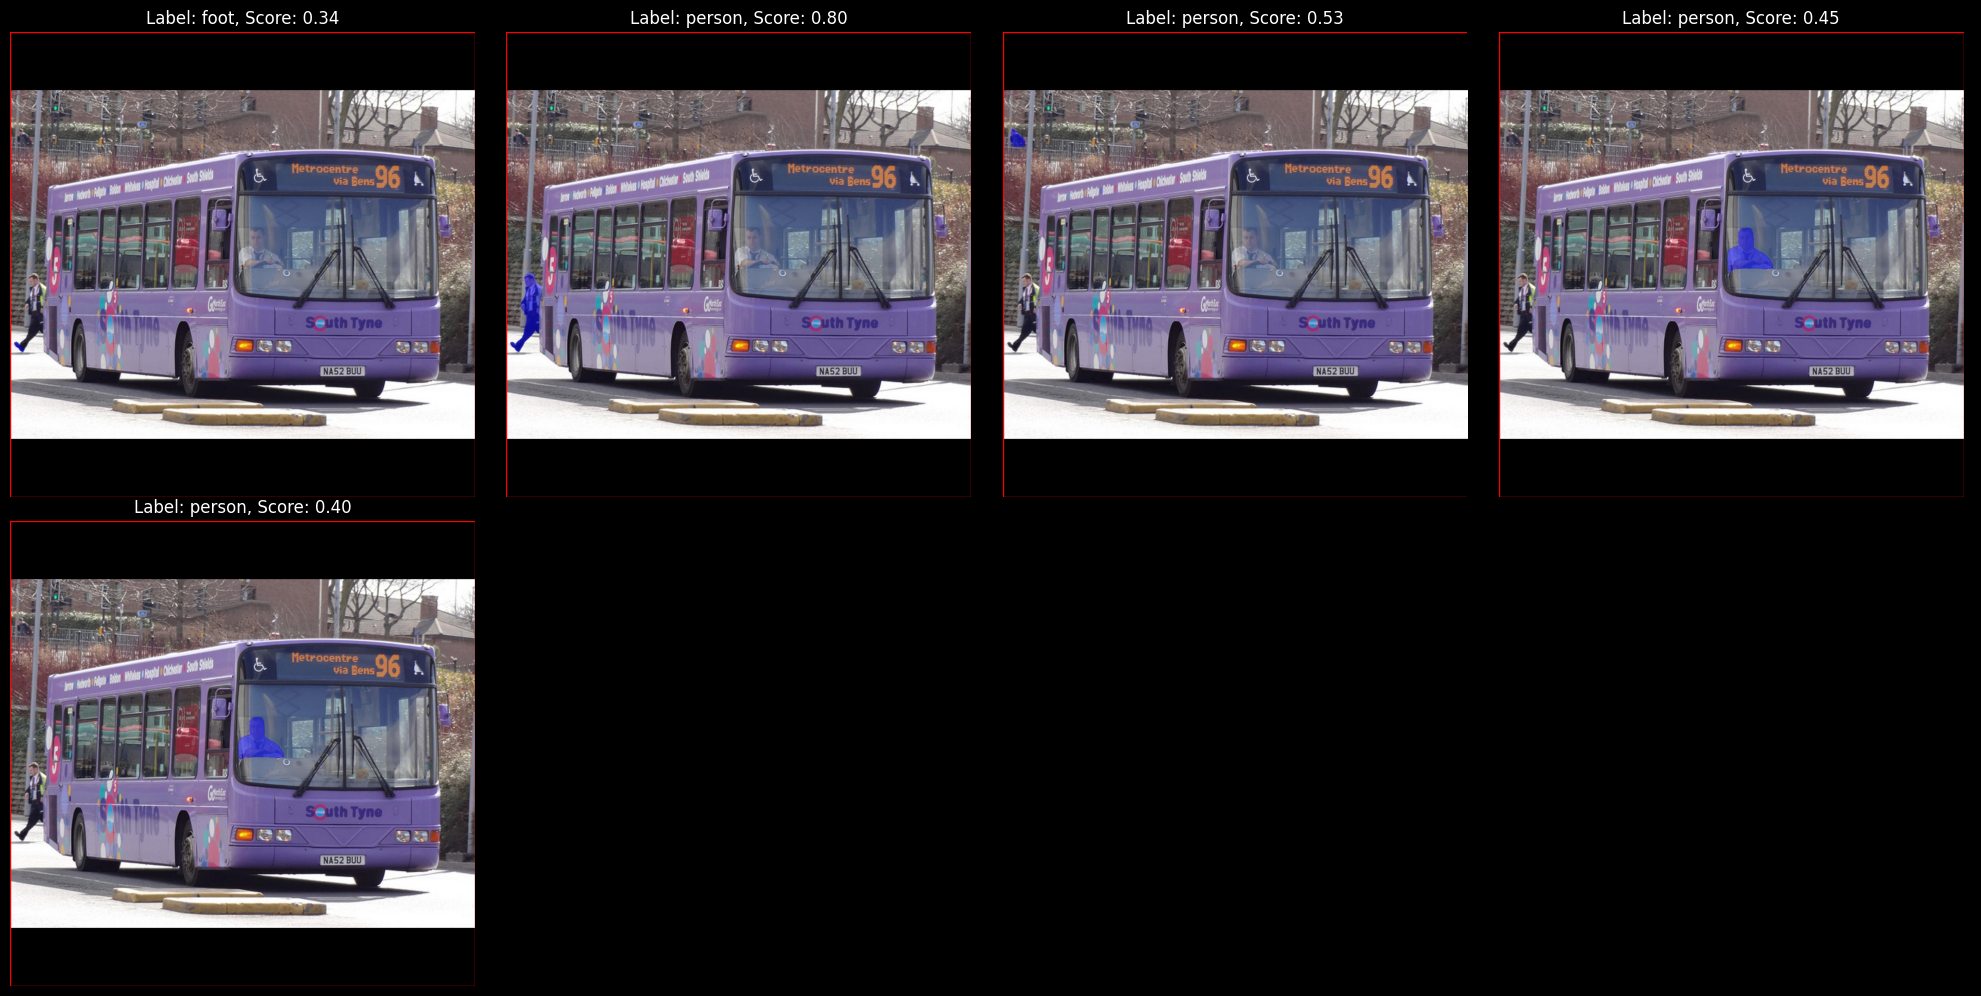

In [8]:
r = SAMResults(images[1], labels_dict, **unformatted_results[1])
r.display_results()

In [9]:
from utils import get_coco_style_polygons

In [19]:
def get_masks_md(results):
    results_list = []
    for result in results.formatted_results:
        mask = result.get("mask")
        # coco_polygons = get_coco_style_polygons(mask)

        # format the polygons
        # result.update({"polygons": coco_polygons})
        result.pop("mask")
        results_list.append(result)
    return results_list

In [23]:
mask_metadata = {}
image_ids = [0, 1, 2, 3]
for image_id, image, raw_result in zip(image_ids, images, unformatted_results):
    if raw_result.get('masks') is None:
        mask_md_row = dict(zip(str(image_id), [None]))

    else:

        result = SAMResults(image, labels_dict, **raw_result)
        mask_md = get_masks_md(result)

        mask_md_row = dict(zip(str(image_id), [mask_md]))

    mask_metadata.update(mask_md_row)

In [24]:
mask_metadata

{'0': None,
 '1': [{'label': 'foot',
   'score': 0.34003666043281555,
   'box': [9.188827514648438,
    681.5780029296875,
    33.04736328125,
    704.944580078125],
   'label_id': 7},
  {'label': 'person',
   'score': 0.7975491881370544,
   'box': [8.739665985107422,
    530.0908203125,
    80.44244384765625,
    705.1132202148438],
   'label_id': 9},
  {'label': 'person',
   'score': 0.5310704708099365,
   'box': [14.91282844543457,
    211.3216094970703,
    50.12627410888672,
    254.43028259277344],
   'label_id': 9},
  {'label': 'person',
   'score': 0.45317715406417847,
   'box': [501.748779296875,
    429.7416687011719,
    605.1455078125,
    571.1533203125],
   'label_id': 9},
  {'label': 'person',
   'score': 0.40320247411727905,
   'box': [501.8542175292969,
    429.5603332519531,
    605.4620971679688,
    524.2384033203125],
   'label_id': 9}]}

: 